In [1]:
import pandas as pd

df = pd.read_csv("../data/raw/legal_text_classification.csv")
df.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


Aqui analizamos la estructura del dataset para entender que tenemos. Con info() revisamos si hay valores nulos y los tipos de datos. Con value_counts() observamos cuantos documentos hay por cada categoria. Esto es importante porque si una clase tiene muchos mas datos que otra, el modelo puede sesgarse.

In [2]:
df.info()
df.describe()
df['case_outcome'].value_counts()

<class 'pandas.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   case_id       24985 non-null  str  
 1   case_outcome  24985 non-null  str  
 2   case_title    24985 non-null  str  
 3   case_text     24809 non-null  str  
dtypes: str(4)
memory usage: 780.9 KB


case_outcome
cited            12219
referred to       4384
applied           2448
followed          2256
considered        1712
discussed         1024
distinguished      608
related            113
affirmed           113
approved           108
Name: count, dtype: int64

En este bloque limpiamos los textos legales con un pipeline mejorado. Convertimos a minusculas, eliminamos numeros y puntuacion, quitamos stopwords y aplicamos **lematizacion** con WordNetLemmatizer: reduce palabras a su forma base ("exercised" -> "exercise", "courts" -> "court"). Tambien eliminamos tokens de menos de 3 caracteres y filas con texto vacio.

In [3]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

df = df.dropna(subset=["case_text"]).reset_index(drop=True)
df["clean_text"] = df["case_text"].astype(str).apply(clean_text)
df[["case_text", "clean_text"]].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\isave\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\isave\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,case_text,clean_text
0,Ordinarily that discretion will be exercised s...,ordinarily discretion exercised cost follow ev...
1,The general principles governing the exercise ...,general principle governing exercise discretio...
2,Ordinarily that discretion will be exercised s...,ordinarily discretion exercised cost follow ev...
3,The general principles governing the exercise ...,general principle governing exercise discretio...
4,The preceding general principles inform the ex...,preceding general principle inform exercise di...


Aqui unimos todos los textos limpios y contamos cuantas veces aparece cada palabra. Esto permite identificar los terminos mas comunes en el lenguaje juridico del dataset.

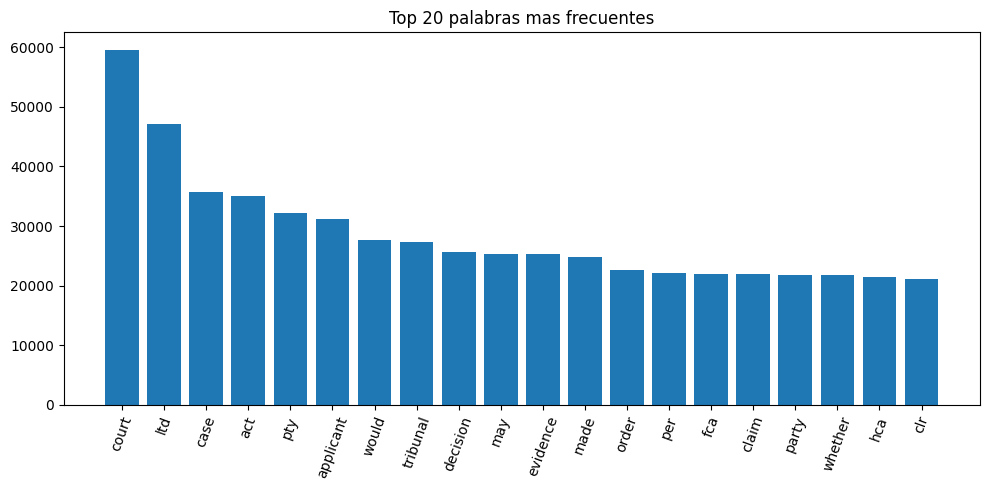

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

all_words = " ".join(df["clean_text"]).split()
freq = Counter(all_words)
common = freq.most_common(20)
words, counts = zip(*common)

plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation=70)
plt.title("Top 20 palabras mas frecuentes")
plt.tight_layout()
plt.show()

Convertimos el texto en vectores numericos usando **TF-IDF mejorado**. Ademas de palabras individuales (unigramas), incluimos **bigramas** (pares de palabras), lo que captura frases como "referred to" o "applied for". Con min_df=3 eliminamos terminos rarisimos y con max_df=0.85 los demasiado comunes. sublinear_tf=True aplica logaritmo al TF para suavizar pesos extremos.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.85,
    sublinear_tf=True
)

X = vectorizer.fit_transform(df["clean_text"])
y = df["case_outcome"]

print(f"Dimensiones de la matriz TF-IDF: {X.shape}")
print(f"Distribucion de clases:\n{y.value_counts()}")

Dimensiones de la matriz TF-IDF: (24809, 10000)
Distribucion de clases:
case_outcome
cited            12110
referred to       4363
applied           2438
followed          2252
considered        1699
discussed         1018
distinguished      603
related            112
approved           108
affirmed           106
Name: count, dtype: int64


Dividimos el dataset con stratify=y para garantizar que cada particion tenga la misma proporcion de clases. Entrenamos una Regresion Logistica con class_weight="balanced" como modelo baseline mejorado.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_lr = LogisticRegression(max_iter=1000, class_weight="balanced", C=1.0)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("=== Regresion Logistica (baseline mejorado) ===")
print(classification_report(y_test, y_pred_lr, zero_division=0))

=== Regresion Logistica (baseline mejorado) ===
               precision    recall  f1-score   support

     affirmed       0.30      0.76      0.43        21
      applied       0.26      0.37      0.30       488
     approved       0.09      0.24      0.13        21
        cited       0.77      0.43      0.55      2422
   considered       0.24      0.38      0.30       340
    discussed       0.20      0.46      0.28       204
distinguished       0.21      0.48      0.29       121
     followed       0.28      0.34      0.30       450
  referred to       0.44      0.45      0.45       873
      related       0.15      0.55      0.23        22

     accuracy                           0.42      4962
    macro avg       0.29      0.45      0.33      4962
 weighted avg       0.54      0.42      0.45      4962



## Comparacion de Modelos

Evaluamos cuatro algoritmos sobre los mismos datos para identificar el mejor. Usamos F1 Macro como metrica principal porque trata todas las clases por igual, penalizando el mal desempeno en clases minoritarias.

In [7]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np

modelos = {
    "Logistic Regression": model_lr,
    "Naive Bayes": MultinomialNB(alpha=0.1),
    "LinearSVC": LinearSVC(class_weight="balanced", max_iter=2000, C=1.0),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42, n_jobs=-1)
}

resultados = {}
for nombre, modelo in modelos.items():
    if nombre != "Logistic Regression":
        modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = np.mean(y_pred == y_test)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    resultados[nombre] = {"Accuracy": acc, "F1 Macro": f1_macro, "F1 Weighted": f1_weighted}
    print("\n" + "="*40)
    print(f"  {nombre}")
    print(f"  Accuracy:    {acc:.4f}")
    print(f"  F1 Macro:    {f1_macro:.4f}")
    print(f"  F1 Weighted: {f1_weighted:.4f}")

df_resultados = pd.DataFrame(resultados).T.sort_values("F1 Macro", ascending=False)
print("\n=== Ranking de modelos por F1 Macro ===")
print(df_resultados.round(4))


  Logistic Regression
  Accuracy:    0.4206
  F1 Macro:    0.3265
  F1 Weighted: 0.4490

  Naive Bayes
  Accuracy:    0.5177
  F1 Macro:    0.2356
  F1 Weighted: 0.4246

  LinearSVC
  Accuracy:    0.5351
  F1 Macro:    0.3965
  F1 Weighted: 0.5457

  Random Forest
  Accuracy:    0.5713
  F1 Macro:    0.3333
  F1 Weighted: 0.5111

=== Ranking de modelos por F1 Macro ===
                     Accuracy  F1 Macro  F1 Weighted
LinearSVC              0.5351    0.3965       0.5457
Random Forest          0.5713    0.3333       0.5111
Logistic Regression    0.4206    0.3265       0.4490
Naive Bayes            0.5177    0.2356       0.4246


## Optimizacion de Hiperparametros con GridSearchCV

Ajustamos los hiperparametros de LinearSVC mediante busqueda en grilla con validacion cruzada de 5 pliegues, optimizando F1 macro.

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid_svc = {"C": [0.01, 0.1, 1.0, 10.0]}
svc_base = LinearSVC(class_weight="balanced", max_iter=3000)

grid_search = GridSearchCV(
    svc_base, param_grid_svc,
    cv=5, scoring="f1_macro", n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

print(f"Mejor parametro: {grid_search.best_params_}")
print(f"Mejor F1 Macro en CV: {grid_search.best_score_:.4f}")

mejor_modelo = grid_search.best_estimator_
y_pred_best = mejor_modelo.predict(X_test)

print("\n=== Mejor Modelo (LinearSVC optimizado) ===")
print(classification_report(y_test, y_pred_best, zero_division=0))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejor parametro: {'C': 1.0}
Mejor F1 Macro en CV: 0.3993

=== Mejor Modelo (LinearSVC optimizado) ===
               precision    recall  f1-score   support

     affirmed       0.37      0.52      0.43        21
      applied       0.33      0.35      0.34       488
     approved       0.20      0.38      0.26        21
        cited       0.74      0.65      0.69      2422
   considered       0.33      0.40      0.36       340
    discussed       0.27      0.42      0.33       204
distinguished       0.31      0.38      0.34       121
     followed       0.34      0.36      0.35       450
  referred to       0.52      0.51      0.52       873
      related       0.37      0.32      0.34        22

     accuracy                           0.54      4962
    macro avg       0.38      0.43      0.40      4962
 weighted avg       0.56      0.54      0.55      4962



## Manejo de Desbalance de Clases

El dataset tiene un desbalance extremo: "cited" tiene 12,219 ejemplos mientras "affirmed" y "approved" tienen solo ~108. Esto impide que el modelo aprenda las clases minoritarias correctamente.

Estrategia en dos pasos:
1. **Agrupar** las 3 clases con menos de 200 ejemplos en "otros" (de 10 a 8 clases)
2. **Balancear** aplicando oversampling sobre el conjunto de entrenamiento

Comparamos dos tecnicas de balanceo: **Random Oversampling** y **SMOTE**.

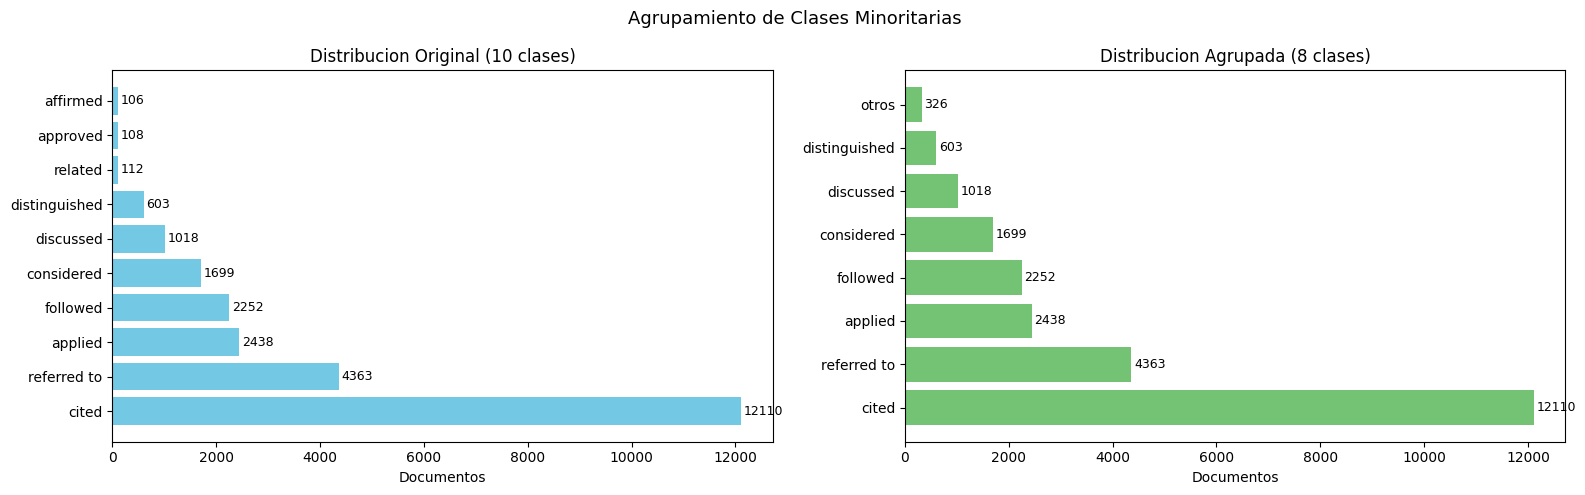

Clases originales:  10
Clases agrupadas:   8
Ratio max/min antes:  114x
Ratio max/min despues: 37x


In [9]:
import matplotlib.pyplot as plt

# Paso 1: Agrupar clases minoritarias
dist_original = df["case_outcome"].value_counts()

clases_minoritarias = ["affirmed", "approved", "related"]
df["case_outcome_agrupado"] = df["case_outcome"].apply(
    lambda x: "otros" if x in clases_minoritarias else x
)
dist_agrupada = df["case_outcome_agrupado"].value_counts()

# Visualizacion comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].barh(dist_original.index, dist_original.values, color="#5bc0de", alpha=0.85)
axes[0].set_title("Distribucion Original (10 clases)")
axes[0].set_xlabel("Documentos")
for i, v in enumerate(dist_original.values):
    axes[0].text(v + 50, i, str(v), va="center", fontsize=9)

axes[1].barh(dist_agrupada.index, dist_agrupada.values, color="#5cb85c", alpha=0.85)
axes[1].set_title("Distribucion Agrupada (8 clases)")
axes[1].set_xlabel("Documentos")
for i, v in enumerate(dist_agrupada.values):
    axes[1].text(v + 50, i, str(v), va="center", fontsize=9)

plt.suptitle("Agrupamiento de Clases Minoritarias", fontsize=13)
plt.tight_layout()
plt.savefig("../reports/distribucion_clases.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Clases originales:  {df['case_outcome'].nunique()}")
print(f"Clases agrupadas:   {df['case_outcome_agrupado'].nunique()}")
print(f"Ratio max/min antes:  {dist_original.max() // dist_original.min()}x")
print(f"Ratio max/min despues: {dist_agrupada.max() // dist_agrupada.min()}x")

## Balanceo con Random Oversampling

Aplicamos **Random Oversampling** sobre el conjunto de entrenamiento (nunca sobre test): duplica aleatoriamente ejemplos reales de las clases minoritarias hasta igualar la representacion de la clase mayoritaria. Es seguro con TF-IDF porque no genera vectores sinteticos, solo reutiliza ejemplos reales.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# TF-IDF sobre clases agrupadas
vectorizer_ag = TfidfVectorizer(
    max_features=10000, ngram_range=(1, 2),
    min_df=3, max_df=0.85, sublinear_tf=True
)
X_ag = vectorizer_ag.fit_transform(df["clean_text"])
y_ag = df["case_outcome_agrupado"]

# Split estratificado
X_train_ag, X_test_ag, y_train_ag, y_test_ag = train_test_split(
    X_ag, y_ag, test_size=0.2, random_state=42, stratify=y_ag
)

print("Distribucion ANTES del balanceo (train):")
print(pd.Series(y_train_ag).value_counts())

# Random Oversampling SOLO sobre train
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_ag, y_train_ag)

print(f"\nDistribucion DESPUES del balanceo (train):")
print(pd.Series(y_train_ros).value_counts())
print(f"\nTrain antes:  {X_train_ag.shape[0]} muestras")
print(f"Train despues: {X_train_ros.shape[0]} muestras")

# LinearSVC sin class_weight (datos ya balanceados)
modelo_ros = LinearSVC(max_iter=3000, C=1.0)
modelo_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = modelo_ros.predict(X_test_ag)

print("\n=== LinearSVC + Agrupacion + Random Oversampling ===")
print(classification_report(y_test_ag, y_pred_ros, zero_division=0))

f1_ros  = f1_score(y_test_ag, y_pred_ros, average="macro", zero_division=0)
acc_ros = accuracy_score(y_test_ag, y_pred_ros)
print(f"F1 Macro:  {f1_ros:.4f}")
print(f"Accuracy:  {acc_ros:.4f}")

Distribucion ANTES del balanceo (train):
case_outcome_agrupado
cited            9688
referred to      3490
applied          1950
followed         1802
considered       1359
discussed         814
distinguished     483
otros             261
Name: count, dtype: int64

Distribucion DESPUES del balanceo (train):
case_outcome_agrupado
cited            9688
referred to      9688
applied          9688
discussed        9688
followed         9688
otros            9688
considered       9688
distinguished    9688
Name: count, dtype: int64

Train antes:  19847 muestras
Train despues: 77504 muestras

=== LinearSVC + Agrupacion + Random Oversampling ===
               precision    recall  f1-score   support

      applied       0.30      0.37      0.33       488
        cited       0.74      0.59      0.66      2422
   considered       0.34      0.41      0.37       340
    discussed       0.28      0.37      0.32       204
distinguished       0.41      0.45      0.43       120
     followed       0.

## Balanceo con SMOTE

Aplicamos **SMOTE** (Synthetic Minority Oversampling Technique) sobre el conjunto de entrenamiento. A diferencia de Random Oversampling, SMOTE genera ejemplos sinteticos interpolando entre vecinos reales de la misma clase, produciendo mayor variedad. Requiere convertir la matriz TF-IDF dispersa a densa.

Comparamos con Random Oversampling para determinar cual balancea mejor en este contexto.

In [15]:
from imblearn.over_sampling import SMOTE

# Usamos X_train_ag / X_test_ag de la celda anterior
print("Aplicando SMOTE... (puede tardar unos minutos)")

# SMOTE requiere matriz densa
X_train_dense = X_train_ag.toarray()
X_test_dense  = X_test_ag.toarray()

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_sm, y_train_sm = smote.fit_resample(X_train_dense, y_train_ag)

print(f"Train antes de SMOTE:  {X_train_dense.shape[0]} muestras")
print(f"Train despues de SMOTE: {X_train_sm.shape[0]} muestras")
print(f"\nDistribucion despues de SMOTE:")
print(pd.Series(y_train_sm).value_counts())

# LinearSVC sin class_weight (datos ya balanceados)
modelo_smote = LinearSVC(max_iter=3000, C=1.0)
modelo_smote.fit(X_train_sm, y_train_sm)
y_pred_smote = modelo_smote.predict(X_test_dense)

print("\n=== LinearSVC + Agrupacion + SMOTE ===")
print(classification_report(y_test_ag, y_pred_smote, zero_division=0))

f1_smote  = f1_score(y_test_ag, y_pred_smote, average="macro", zero_division=0)
acc_smote = accuracy_score(y_test_ag, y_pred_smote)
print(f"F1 Macro:  {f1_smote:.4f}")
print(f"Accuracy:  {acc_smote:.4f}")

Aplicando SMOTE... (puede tardar unos minutos)
Train antes de SMOTE:  19847 muestras
Train despues de SMOTE: 77504 muestras

Distribucion despues de SMOTE:
case_outcome_agrupado
cited            9688
referred to      9688
applied          9688
discussed        9688
followed         9688
otros            9688
considered       9688
distinguished    9688
Name: count, dtype: int64

=== LinearSVC + Agrupacion + SMOTE ===
               precision    recall  f1-score   support

      applied       0.30      0.36      0.33       488
        cited       0.74      0.61      0.67      2422
   considered       0.34      0.41      0.37       340
    discussed       0.29      0.35      0.32       204
distinguished       0.36      0.42      0.39       120
     followed       0.34      0.42      0.38       450
        otros       0.36      0.43      0.39        65
  referred to       0.50      0.54      0.52       873

     accuracy                           0.53      4962
    macro avg       0.40    

## Comparacion Final: Tres Enfoques

Comparamos los tres enfoques para manejar el desbalance:

1. **Baseline:** LinearSVC con class_weight="balanced", datos originales (10 clases)
2. **Agrupacion + Random Oversampling:** 8 clases, duplicar ejemplos reales
3. **Agrupacion + SMOTE:** 8 clases, ejemplos sinteticos interpolados

F1 Macro es la metrica principal. Un F1 Macro mas alto indica mejor desempeno en todas las clases por igual, incluyendo las minoritarias.

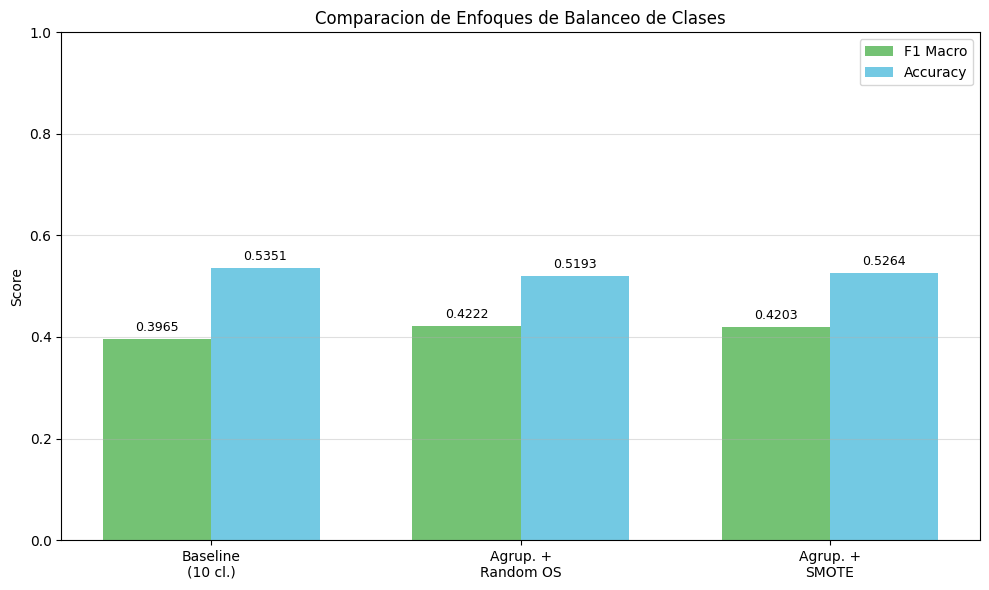


=== Tabla Resumen ===
                     Enfoque F1 Macro Accuracy
           Baseline (10 cl.)   0.3965   0.5351
Agrup. + Random Oversampling   0.4222   0.5193
              Agrup. + SMOTE   0.4203   0.5264

Mejor F1 Macro: Agrup. + Random Oversampling (0.4222)


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

enfoques    = ["Baseline\n(10 cl.)", "Agrup. +\nRandom OS", "Agrup. +\nSMOTE"]
f1_valores  = [0.3965, f1_ros, f1_smote]
acc_valores = [0.5351, acc_ros, acc_smote]

x = np.arange(len(enfoques))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, f1_valores,  width, label="F1 Macro", color="#5cb85c", alpha=0.85)
bars2 = ax.bar(x + width/2, acc_valores, width, label="Accuracy", color="#5bc0de", alpha=0.85)
ax.set_ylabel("Score")
ax.set_title("Comparacion de Enfoques de Balanceo de Clases")
ax.set_xticks(x)
ax.set_xticklabels(enfoques)
ax.legend()
ax.set_ylim(0, 1.0)
ax.yaxis.grid(True, alpha=0.4)
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{bar.get_height():.4f}", ha="center", va="bottom", fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{bar.get_height():.4f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.savefig("../reports/comparacion_balanceo.png", dpi=150, bbox_inches="tight")
plt.show()

resumen = pd.DataFrame({
    "Enfoque": ["Baseline (10 cl.)", "Agrup. + Random Oversampling", "Agrup. + SMOTE"],
    "F1 Macro":  [f"{v:.4f}" for v in f1_valores],
    "Accuracy":  [f"{v:.4f}" for v in acc_valores]
})
print("\n=== Tabla Resumen ===")
print(resumen.to_string(index=False))
idx_mejor = f1_valores.index(max(f1_valores))
print(f"\nMejor F1 Macro: {resumen.iloc[idx_mejor]['Enfoque']} ({max(f1_valores):.4f})")

## Visualizaciones del Mejor Modelo

La **matriz de confusion** muestra cuantos documentos de cada clase real fueron clasificados correctamente. La **comparacion de F1 por clase** muestra el avance respecto al modelo base original sin mejoras.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import numpy as np

clases_best = sorted(y.unique())

# Matriz de Confusion
cm = confusion_matrix(y_test, y_pred_best, labels=clases_best)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases_best)
disp.plot(ax=ax, colorbar=True, cmap="Blues", xticks_rotation=45)
ax.set_title("Matriz de Confusion - LinearSVC Optimizado", fontsize=13)
plt.tight_layout()
plt.savefig("../reports/confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

# F1 por clase: base vs mejor
model_base = LogisticRegression(max_iter=1000)
model_base.fit(X_train, y_train)
y_pred_base = model_base.predict(X_test)

f1_base     = f1_score(y_test, y_pred_base, labels=clases_best, average=None, zero_division=0)
f1_best_arr = f1_score(y_test, y_pred_best, labels=clases_best, average=None, zero_division=0)

x = np.arange(len(clases_best))
width = 0.35
fig, ax = plt.subplots(figsize=(13, 6))
ax.bar(x - width/2, f1_base,     width, label="LR Base (original)",      color="#d9534f", alpha=0.8)
ax.bar(x + width/2, f1_best_arr, width, label="LinearSVC Optimizado",    color="#5cb85c", alpha=0.8)
ax.set_xlabel("Clase")
ax.set_ylabel("F1-Score")
ax.set_title("F1-Score por Clase: Modelo Base vs LinearSVC Optimizado")
ax.set_xticks(x)
ax.set_xticklabels(clases_best, rotation=30, ha="right")
ax.legend()
ax.set_ylim(0, 1.0)
ax.yaxis.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig("../reports/f1_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## Guardado del Mejor Modelo

Serializamos el vectorizador TF-IDF y el modelo final con **joblib**. Tambien guardamos las metricas en reports/metrics.json.

In [ ]:
import joblib
import json
import os
from sklearn.metrics import accuracy_score

os.makedirs("../models", exist_ok=True)

joblib.dump(vectorizer, "../models/tfidf_vectorizer.pkl")
joblib.dump(mejor_modelo, "../models/best_model.pkl")
print("Modelo y vectorizador guardados en ../models/")

metricas = {
    "modelo": "LinearSVC (GridSearchCV optimizado)",
    "mejores_parametros": grid_search.best_params_,
    "accuracy": round(accuracy_score(y_test, y_pred_best), 4),
    "f1_macro": round(f1_score(y_test, y_pred_best, average="macro", zero_division=0), 4),
    "f1_weighted": round(f1_score(y_test, y_pred_best, average="weighted", zero_division=0), 4),
    "comparacion_modelos": df_resultados.round(4).to_dict(orient="index")
}

with open("../reports/metrics.json", "w") as f:
    json.dump(metricas, f, indent=2)

print("Metricas guardadas en ../reports/metrics.json")
print(f"  Accuracy:    {metricas['accuracy']}")
print(f"  F1 Macro:    {metricas['f1_macro']}")
print(f"  F1 Weighted: {metricas['f1_weighted']}")

En esta parte analizamos la polaridad y subjetividad del texto usando TextBlob. La polaridad mide si el lenguaje es positivo o negativo (rango -1 a 1). La subjetividad indica que tan objetivo o subjetivo es el texto (0 a 1).

In [ ]:
from textblob import TextBlob

def get_sentiment(text):
    if pd.isna(text):
        return 0.0, 0.0
    blob = TextBlob(str(text))
    return blob.sentiment.polarity, blob.sentiment.subjectivity

df["polarity"], df["subjectivity"] = zip(*df["case_text"].apply(get_sentiment))

Aqui graficamos la distribucion de polaridad y subjetividad. Tambien calculamos el promedio por categoria para comparar si distintos tipos de decisiones legales tienen lenguaje mas positivo o subjetivo.

In [ ]:
import seaborn as sns

sns.histplot(df["polarity"], kde=True)
plt.title("Distribucion de Polaridad")
plt.show()

sns.histplot(df["subjectivity"], kde=True)
plt.title("Distribucion de Subjetividad")
plt.show()

In [ ]:
df.groupby("case_outcome")[["polarity", "subjectivity"]].mean()